In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier  # For alternative model

# Load the dataset
df = pd.read_csv('heart.csv')
print("Dataset loaded successfully.")
print(df.head())  # Preview the first 5 rows
print(df.shape)   # Should be (303, 14)

Dataset loaded successfully.
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  
(1025, 14)


In [ ]:
# Check for missing values
print(df.isnull().sum())  # Should show 0 if clean

# In original UCI data, '?' represents missing; replace if present
df = df.replace('?', np.nan)

# Handle missing values: Drop rows or impute (here, impute with median for numerical columns)
if df.isnull().sum().any():
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for col in numerical_cols:
        df[col].fillna(df[col].median(), inplace=True)
    print("Missing values handled via median imputation.")

# Check data types and convert if needed (all should be numeric)
print(df.dtypes)  # Ensure int/float

# Basic statistics to spot outliers
print(df.describe())

# Handle potential outliers (e.g., cap extreme values in chol > 500, but rare in this dataset)
df['chol'] = np.where(df['chol'] > 500, df['chol'].median(), df['chol'])  # Example capping

print("Data cleaning complete.")

               age          sex           cp     trestbps        chol  \
count  1025.000000  1025.000000  1025.000000  1025.000000  1025.00000   
mean     54.434146     0.695610     0.942439   131.611707   246.00000   
std       9.072290     0.460373     1.029641    17.516718    51.59251   
min      29.000000     0.000000     0.000000    94.000000   126.00000   
25%      48.000000     0.000000     0.000000   120.000000   211.00000   
50%      56.000000     1.000000     1.000000   130.000000   240.00000   
75%      61.000000     1.000000     2.000000   140.000000   275.00000   
max      77.000000     1.000000     3.000000   200.000000   564.00000   

               fbs      restecg      thalach        exang      oldpeak  \
count  1025.000000  1025.000000  1025.000000  1025.000000  1025.000000   
mean      0.149268     0.529756   149.114146     0.336585     1.071512   
std       0.356527     0.527878    23.005724     0.472772     1.175053   
min       0.000000     0.000000    71.000000  

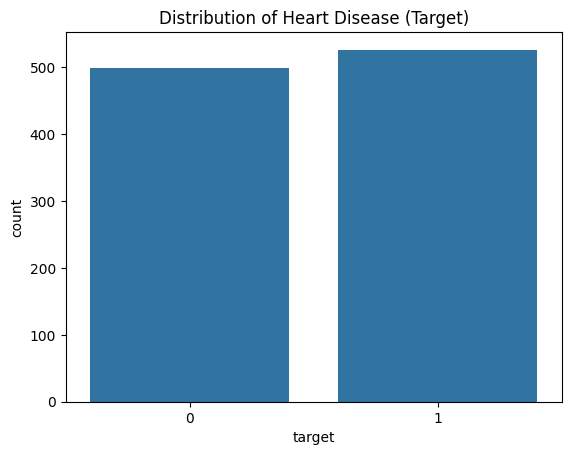

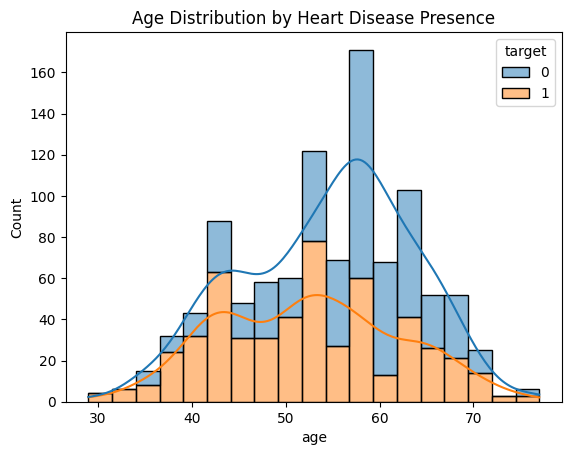

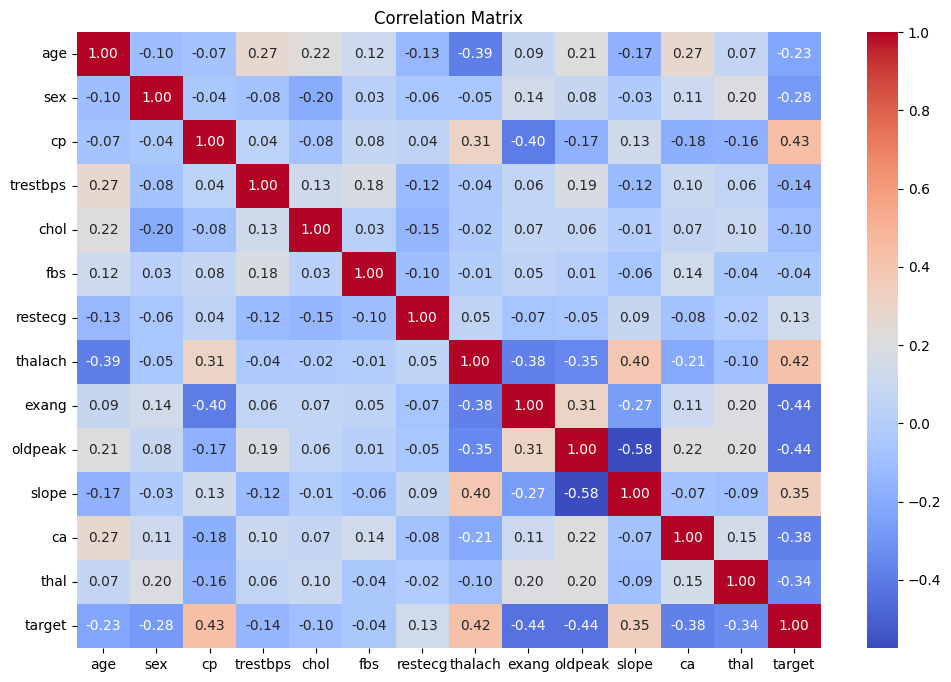

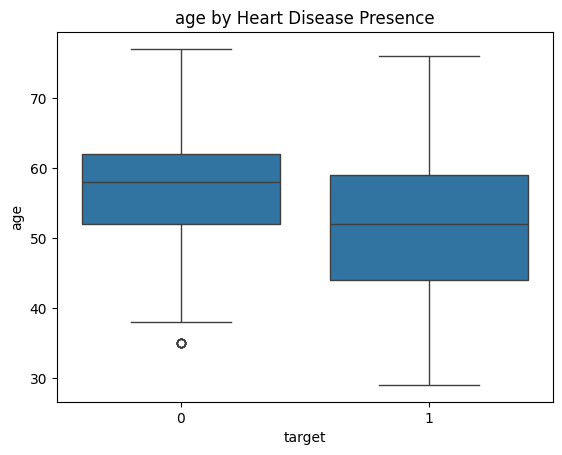

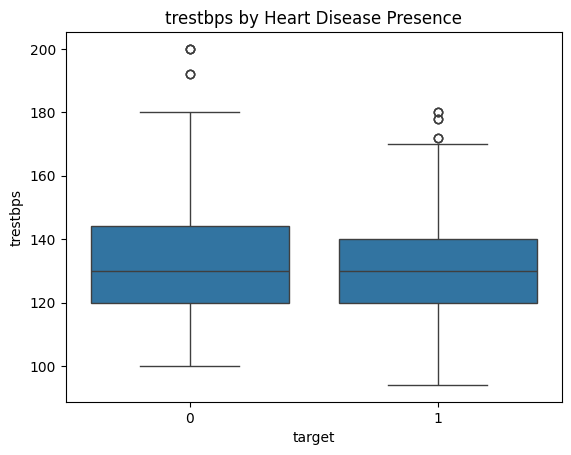

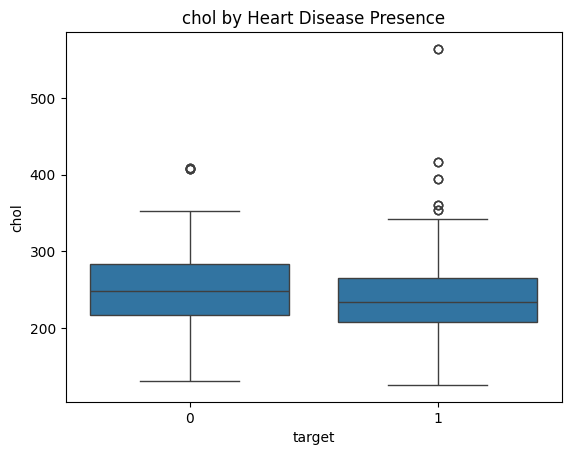

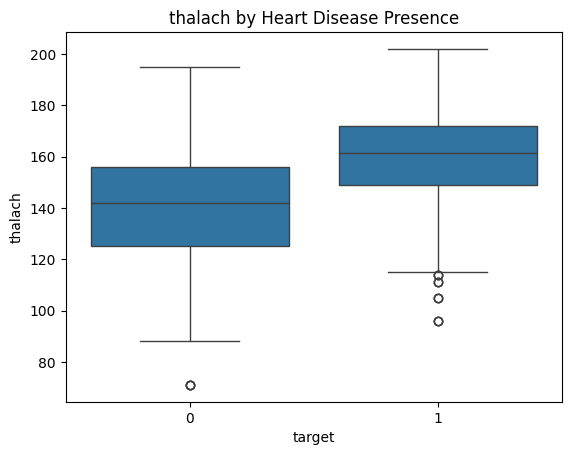

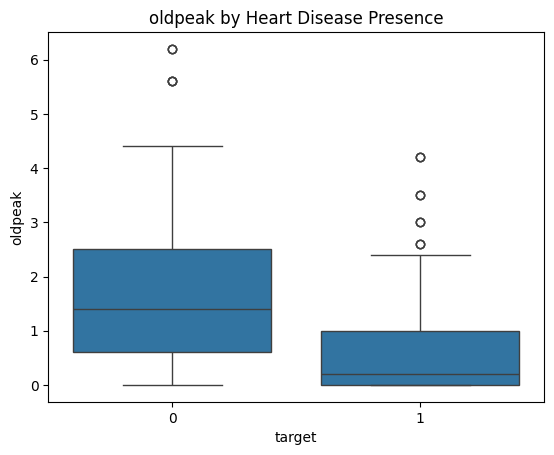

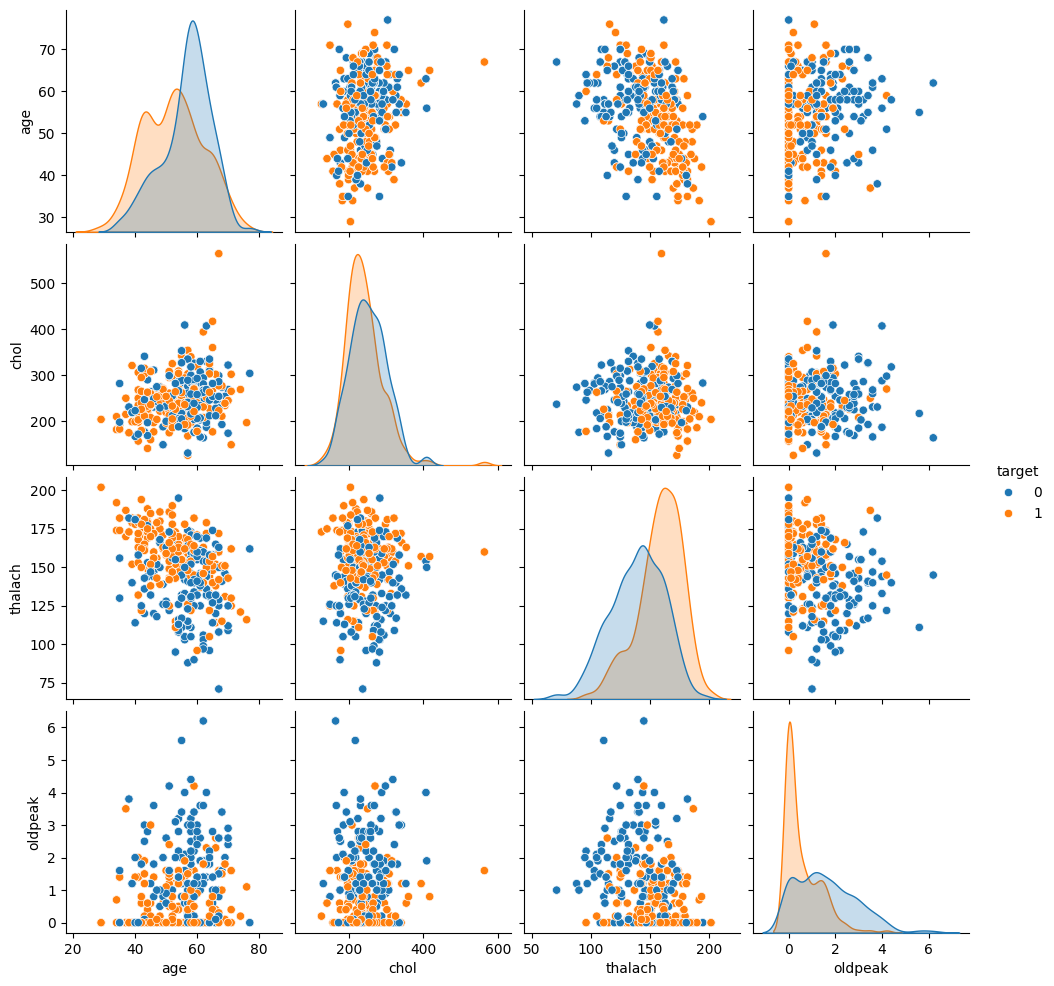

EDA complete. Key insights: Age, chest pain type, and max heart rate are influential.


In [3]:
# Summary statistics
print(df.describe())

# Target distribution (balanced check)
sns.countplot(x='target', data=df)
plt.title('Distribution of Heart Disease (Target)')
plt.show()  # ~165 with disease (1), ~138 without (0) – fairly balanced

# Age distribution by target
sns.histplot(data=df, x='age', hue='target', multiple='stack', kde=True)
plt.title('Age Distribution by Heart Disease Presence')
plt.show()  # Higher risk in 40-60 age group

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()  # Strong correlations: cp, thalach positively with target; oldpeak, ca negatively

# Boxplots for key features
for col in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']:
    sns.boxplot(x='target', y=col, data=df)
    plt.title(f'{col} by Heart Disease Presence')
    plt.show()  # e.g., Higher thalach (max HR) in no-disease group

# Pairplot for selected features (subset to avoid overload)
sns.pairplot(df[['age', 'chol', 'thalach', 'oldpeak', 'target']], hue='target')
plt.show()

print("EDA complete. Key insights: Age, chest pain type, and max heart rate are influential.")

In [4]:
# Features and target
X = df.drop('target', axis=1)
y = df['target']

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features (important for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

# Alternative: Decision Tree
# model = DecisionTreeClassifier(random_state=42)
# model.fit(X_train, y_train)  # No scaling needed for trees

print("Model trained successfully.")

Model trained successfully.


Accuracy: 0.7951


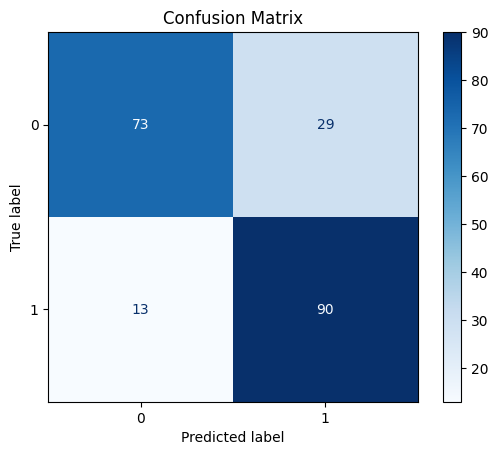

ROC-AUC: 0.8787


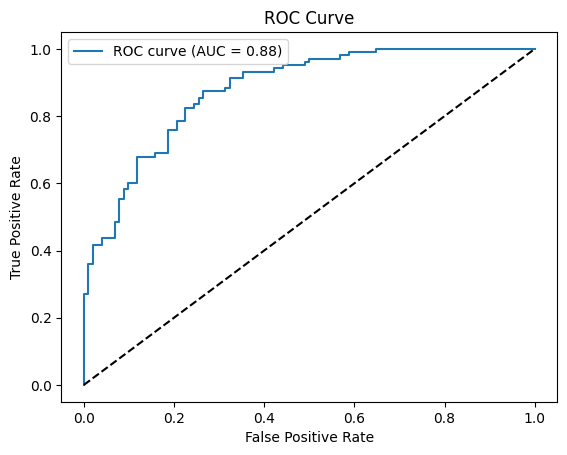

Evaluation complete. Model performs well if AUC > 0.85.


In [5]:
# Predictions
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for ROC

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")  # Typically ~0.85-0.90

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
# Interpretation: Low false negatives crucial in medical (missed diagnoses)

# ROC-AUC
auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC: {auc:.4f}")  # Typically ~0.90-0.95

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print("Evaluation complete. Model performs well if AUC > 0.85.")

     Feature  Importance
2         cp    0.885835
11        ca    0.847522
1        sex    0.835665
9    oldpeak    0.765406
12      thal    0.656856
7    thalach    0.652826
4       chol    0.447276
8      exang    0.420235
10     slope    0.343605
3   trestbps    0.320053
6    restecg    0.140804
5        fbs    0.062685
0        age    0.006734


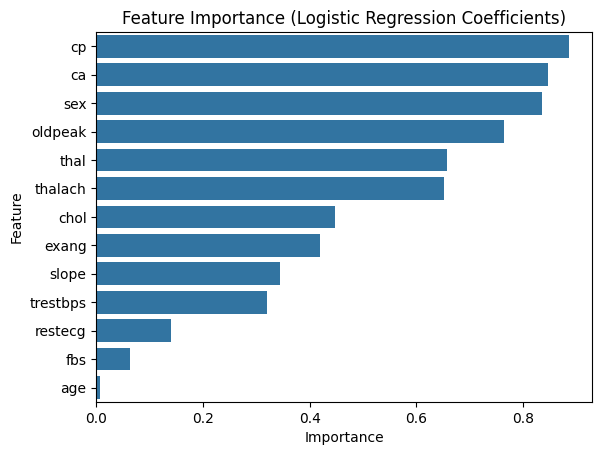

Important features: cp, thalach, oldpeak, ca often rank high.


In [6]:
# For Logistic Regression: Coefficients (absolute value for importance)
importances = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(model.coef_[0])})
importances = importances.sort_values('Importance', ascending=False)
print(importances)

# Plot
sns.barplot(x='Importance', y='Feature', data=importances)
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.show()

# For Decision Tree: Use feature_importances_
# if using DT: importances = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})

print("Important features: cp, thalach, oldpeak, ca often rank high.")